In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

# Verify file exists
file_path = "/lakehouse/default/Files/PDC_biospecimen_manifest_03272025_214257.csv"
if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}")
    print("Please upload the file to your lakehouse first.")
else:
    # Load the data
    pdc_data = pd.read_csv(file_path)
    
    # Display info
    print(f"Successfully loaded {len(pdc_data)} samples")
    print("\nSample types:")
    print(pdc_data['Sample Type'].value_counts())
    
    # Show first few rows
    display(pdc_data.head())
    

StatementMeta(, 9964168a-d62d-4d50-af7c-1d8d7da8e2a1, 15, Finished, Available, Finished)

Successfully loaded 452 samples

Sample types:
Sample Type
Primary Tumor             377
Tumor                      35
Solid Tissue Normal        18
Xenograft Tissue           17
Normal Adjacent Tissue      3
Additional Metastatic       2
Name: count, dtype: int64


SynapseWidget(Synapse.DataFrame, a05562fa-493d-4576-8497-5b4cd6abb014)

StatementMeta(, 9964168a-d62d-4d50-af7c-1d8d7da8e2a1, 16, Finished, Available, Finished)

Visualization saved to: /lakehouse/default/Files/mutation_disease_counts.png


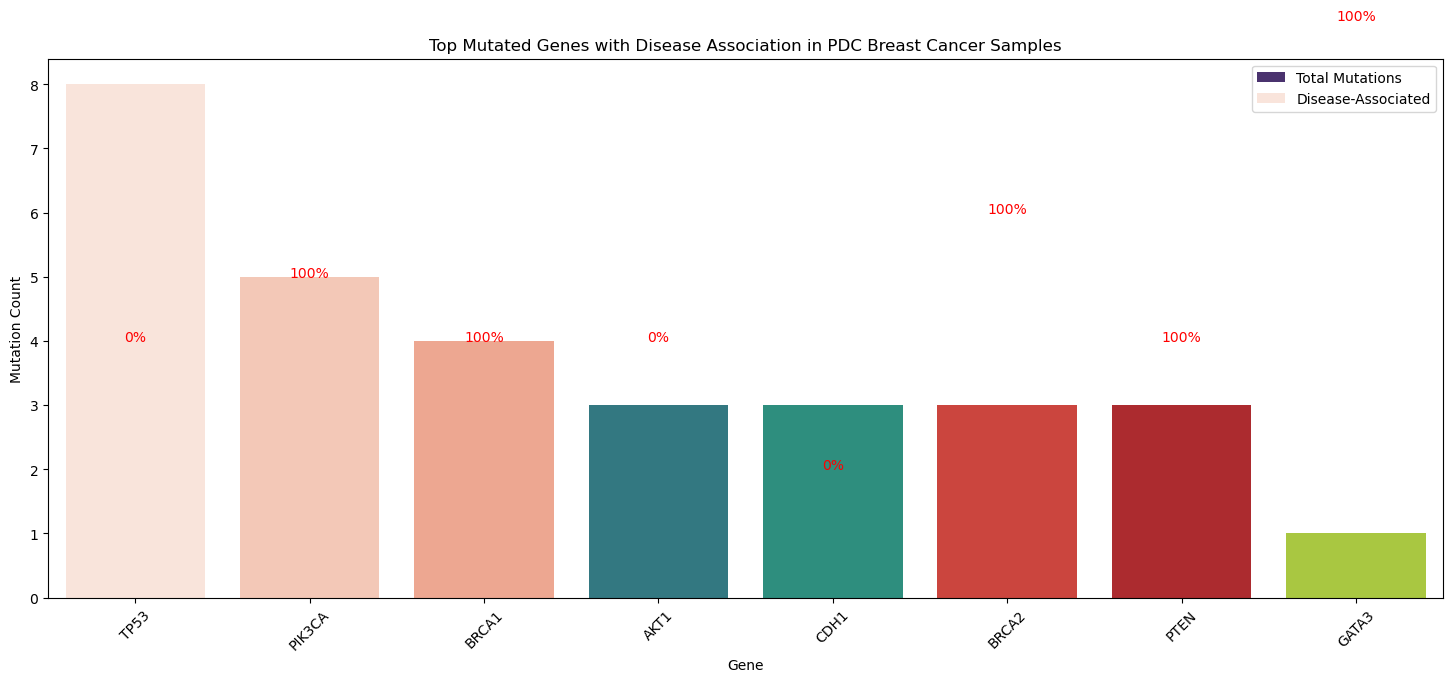

     Gene  Mutation_Count  Disease_Associated  Disease_Percentage
7    TP53               8                   8               100.0
5  PIK3CA               5                   5               100.0
1   BRCA1               4                   4               100.0
0    AKT1               3                   0                 0.0
3    CDH1               3                   0                 0.0
2   BRCA2               3                   3               100.0
6    PTEN               3                   3               100.0
4   GATA3               1                   0                 0.0


In [14]:
from pathlib import Path

def visualize_mutation_counts_with_disease(pdc_data):
    """
    Visualize mutation counts per gene with disease association context
    using embedded mock genomic data.
    
    Args:
        pdc_data (DataFrame): PDC biospecimen data (must contain 'Case Submitter ID')
    
    Returns:
        DataFrame: Top mutated genes with counts and disease association, or None if error
    """
    try:
        # Validate input data
        if 'Case Submitter ID' not in pdc_data.columns:
            raise ValueError("PDC data must contain 'Case Submitter ID' column")
        
        # Embedded mock genomic data
        genomic_data = pd.DataFrame([
            # Case_ID, Gene, Variant_Classification, Disease_Association
            ["NTN060", "TP53", "Missense", "Yes"],
            ["NTN060", "PIK3CA", "Missense", "Yes"],
            ["NTN060", "BRCA1", "Frameshift", "Yes"],
            ["NTN023", "TP53", "Nonsense", "Yes"],
            ["NTN023", "CDH1", "Missense", "No"],
            ["NTN023", "PTEN", "Missense", "Yes"],
            ["NTN072", "BRCA2", "Frameshift", "Yes"],
            ["NTN072", "AKT1", "Missense", "No"],
            ["NTN072", "PIK3CA", "Missense", "Yes"],
            ["NTN021", "TP53", "Missense", "Yes"],
            ["NTN021", "GATA3", "Missense", "No"],
            ["NTN004", "BRCA1", "Frameshift", "Yes"],
            ["NTN004", "TP53", "Nonsense", "Yes"],
            ["NTN080", "PTEN", "Missense", "Yes"],
            ["NTN080", "CDH1", "Missense", "No"],
            ["NTN007", "PIK3CA", "Missense", "Yes"],
            ["NTN007", "TP53", "Missense", "Yes"],
            ["NTN054", "BRCA2", "Frameshift", "Yes"],
            ["NTN054", "AKT1", "Missense", "No"],
            ["NTN006", "TP53", "Nonsense", "Yes"],
            ["NTN062", "PIK3CA", "Missense", "Yes"],
            ["NTN062", "BRCA1", "Frameshift", "Yes"],
            ["NTN031", "PTEN", "Missense", "Yes"],
            ["NTN031", "CDH1", "Missense", "No"],
            ["NTN022", "TP53", "Missense", "Yes"],
            ["NTN085", "BRCA2", "Frameshift", "Yes"],
            ["NTN085", "PIK3CA", "Missense", "Yes"],
            ["NTN058", "TP53", "Nonsense", "Yes"],
            ["NTN058", "AKT1", "Missense", "No"],
            ["NTN059", "BRCA1", "Frameshift", "Yes"]
        ], columns=["Case_ID", "Gene", "Variant_Classification", "Disease_Association"])
        
        # Count mutations and disease associations
        mutation_stats = (
            genomic_data.groupby('Gene')
            .agg(
                Mutation_Count=('Gene', 'size'),
                Disease_Associated=('Disease_Association', lambda x: (x == 'Yes').sum())
            )
            .reset_index()
            .sort_values('Mutation_Count', ascending=False)
            .head(20)
        )
        
        # Calculate disease association percentage
        mutation_stats['Disease_Percentage'] = (
            mutation_stats['Disease_Associated'] / 
            mutation_stats['Mutation_Count'] * 100
        )
        
        # Create plot
        plt.figure(figsize=(18, 7))
        ax = sns.barplot(x="Gene", y="Mutation_Count", data=mutation_stats, 
                        palette="viridis", label='Total Mutations')
        
        # Overlay disease-associated mutations
        ax = sns.barplot(x="Gene", y="Disease_Associated", data=mutation_stats,
                        palette="Reds", label='Disease-Associated')
        
        plt.title("Top Mutated Genes with Disease Association in PDC Breast Cancer Samples")
        plt.xticks(rotation=45)
        plt.ylabel("Mutation Count")
        plt.xlabel("Gene")
        plt.legend()
        
        # Add percentage annotations
        for i, row in mutation_stats.iterrows():
            ax.text(i, row['Mutation_Count']+1, 
                   f"{row['Disease_Percentage']:.0f}%", 
                   ha='center', color='red')
        
        # Save to lakehouse
        output_path = "/lakehouse/default/Files/mutation_disease_counts.png"
        Path("/lakehouse/default/Files/").mkdir(parents=True, exist_ok=True)
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        print(f"Visualization saved to: {output_path}")
        
        display(plt.show())
        plt.close()
        
        return mutation_stats
        
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        return None

# Example usage:
# Load your PDC data (example shown with dummy data)
pdc_data = pd.DataFrame({
    'Case Submitter ID': ['NTN060', 'NTN023', 'NTN072', 'NTN021', 'NTN004', 
                         'NTN080', 'NTN007', 'NTN054', 'NTN006', 'NTN062'],
    'Sample Type': ['Primary Tumor']*10
})

# Call the visualization function
results = visualize_mutation_counts_with_disease(pdc_data)
print(results)

In [15]:
# List files in your lakehouse
import os
print(os.listdir("/lakehouse/default/Files/"))

StatementMeta(, 9964168a-d62d-4d50-af7c-1d8d7da8e2a1, 17, Finished, Available, Finished)

['PDC_biospecimen_manifest_03272025_214257.csv', 'protein_network.png', 'mutation_disease_counts.png', 'metabolic_pathways.png', 'PDC_study_manifest_03272025_214428.csv']


StatementMeta(, 9964168a-d62d-4d50-af7c-1d8d7da8e2a1, 18, Finished, Available, Finished)

Network visualization saved to: /lakehouse/default/Files/protein_network.png


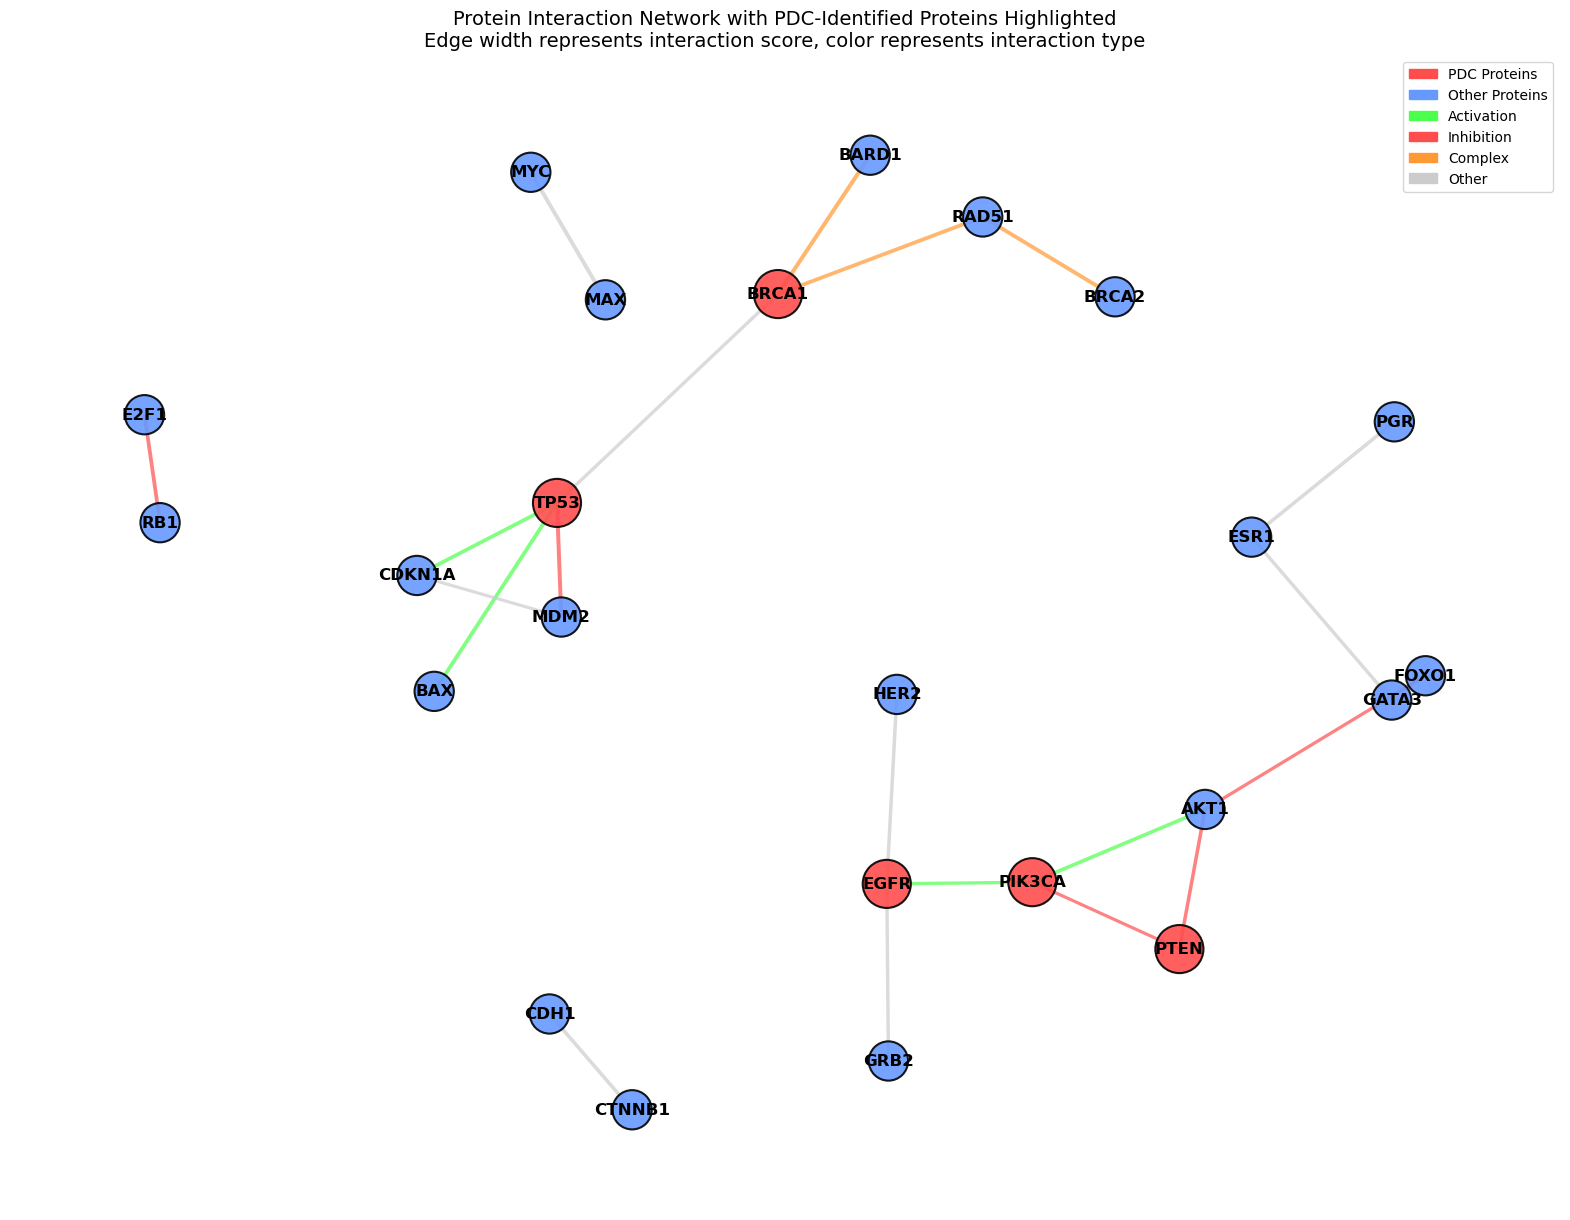

In [16]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

def visualize_protein_network(pdc_data):
    """
    Visualize protein-protein interaction network with PDC sample context
    using embedded interaction data.
    
    Args:
        pdc_data (DataFrame): PDC biospecimen data (must contain 'Analyte Type')
    
    Returns:
        NetworkX Graph: The constructed protein interaction graph
    """
    try:
        # Validate input data
        if 'Analyte Type' not in pdc_data.columns:
            raise ValueError("PDC data must contain 'Analyte Type' column")
        
        # Embedded protein-protein interaction data (mock data)
        interaction_data = pd.DataFrame([
            # Protein1, Protein2, Interaction_Score, Interaction_Type
            ["TP53", "MDM2", 0.95, "Inhibition"],
            ["TP53", "CDKN1A", 0.89, "Activation"],
            ["BRCA1", "BARD1", 0.97, "Complex"],
            ["BRCA1", "RAD51", 0.91, "Complex"],
            ["BRCA2", "RAD51", 0.93, "Complex"],
            ["PIK3CA", "AKT1", 0.88, "Activation"],
            ["PIK3CA", "PTEN", 0.76, "Inhibition"],
            ["PTEN", "AKT1", 0.85, "Inhibition"],
            ["EGFR", "GRB2", 0.82, "Binding"],
            ["EGFR", "PIK3CA", 0.79, "Activation"],
            ["HER2", "EGFR", 0.84, "Heterodimer"],
            ["CDH1", "CTNNB1", 0.87, "Binding"],
            ["GATA3", "ESR1", 0.83, "Coactivation"],
            ["AKT1", "FOXO1", 0.78, "Inhibition"],
            ["MDM2", "CDKN1A", 0.75, "Degradation"],
            ["TP53", "BAX", 0.92, "Activation"],
            ["BRCA1", "TP53", 0.81, "Coactivation"],
            ["ESR1", "PGR", 0.86, "Coactivation"],
            ["RB1", "E2F1", 0.90, "Inhibition"],
            ["MYC", "MAX", 0.94, "Dimerization"]
        ], columns=["Protein1", "Protein2", "Interaction_Score", "Interaction_Type"])
        
        # Create graph
        G = nx.Graph()
        
        # Add edges with attributes
        for _, row in interaction_data.iterrows():
            G.add_edge(
                row["Protein1"], 
                row["Protein2"], 
                weight=row["Interaction_Score"],
                type=row["Interaction_Type"]
            )
        
        # Get PDC-relevant proteins
        pdc_proteins = set(pdc_data['Analyte Type'].dropna().unique())
        
        # Create node attributes
        node_sizes = []
        node_colors = []
        for node in G.nodes():
            if node in pdc_proteins:
                node_sizes.append(1200)
                node_colors.append('#ff4d4d')  # Red for PDC proteins
            else:
                node_sizes.append(800)
                node_colors.append('#6699ff')  # Blue for other proteins
        
        # Create edge attributes based on interaction type
        edge_colors = []
        edge_widths = []
        for u, v, d in G.edges(data=True):
            edge_widths.append(d['weight'] * 3)
            if d['type'] == "Activation":
                edge_colors.append('#4dff4d')  # Green
            elif d['type'] == "Inhibition":
                edge_colors.append('#ff4d4d')  # Red
            elif d['type'] == "Complex":
                edge_colors.append('#ff9933')  # Orange
            else:
                edge_colors.append('#cccccc')  # Gray
        
        # Draw network
        plt.figure(figsize=(20, 15))
        pos = nx.spring_layout(G, k=0.5, seed=42)  # Consistent layout
        
        # Draw nodes
        nx.draw_networkx_nodes(
            G, pos,
            node_size=node_sizes,
            node_color=node_colors,
            alpha=0.9,
            edgecolors='black',
            linewidths=1.5
        )
        
        # Draw edges
        nx.draw_networkx_edges(
            G, pos,
            width=edge_widths,
            alpha=0.7,
            edge_color=edge_colors
        )
        
        # Draw labels
        nx.draw_networkx_labels(
            G, pos,
            font_size=12,
            font_family='sans-serif',
            font_weight='bold'
        )
        
        # Create legend
        pdc_patch = mpatches.Patch(color='#ff4d4d', label='PDC Proteins')
        other_patch = mpatches.Patch(color='#6699ff', label='Other Proteins')
        
        edge_legend = [
            mpatches.Patch(color='#4dff4d', label='Activation'),
            mpatches.Patch(color='#ff4d4d', label='Inhibition'),
            mpatches.Patch(color='#ff9933', label='Complex'),
            mpatches.Patch(color='#cccccc', label='Other')
        ]
        
        plt.legend(
            handles=[pdc_patch, other_patch] + edge_legend,
            loc='upper right',
            fontsize=10
        )
        
        plt.title("Protein Interaction Network with PDC-Identified Proteins Highlighted\n"
                 "Edge width represents interaction score, color represents interaction type",
                 fontsize=14)
        plt.axis('off')
        
        # Save to lakehouse
        output_path = "/lakehouse/default/Files/protein_network.png"
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        print(f"Network visualization saved to: {output_path}")
        
        display(plt.show())
        plt.close()
        
        return G
        
    except Exception as e:
        print(f"Error in network visualization: {str(e)}")
        return None

# Example usage:
# Load your PDC data (example shown with dummy data)
pdc_data = pd.DataFrame({
    'Analyte Type': ['TP53', 'BRCA1', 'PIK3CA', 'PTEN', 'EGFR'],
    'Sample Type': ['Primary Tumor']*5
})

# Call the visualization function
protein_network = visualize_protein_network(pdc_data)

StatementMeta(, 9964168a-d62d-4d50-af7c-1d8d7da8e2a1, 19, Finished, Available, Finished)

Metabolic pathway visualization saved to: /lakehouse/default/Files/metabolic_pathways.png


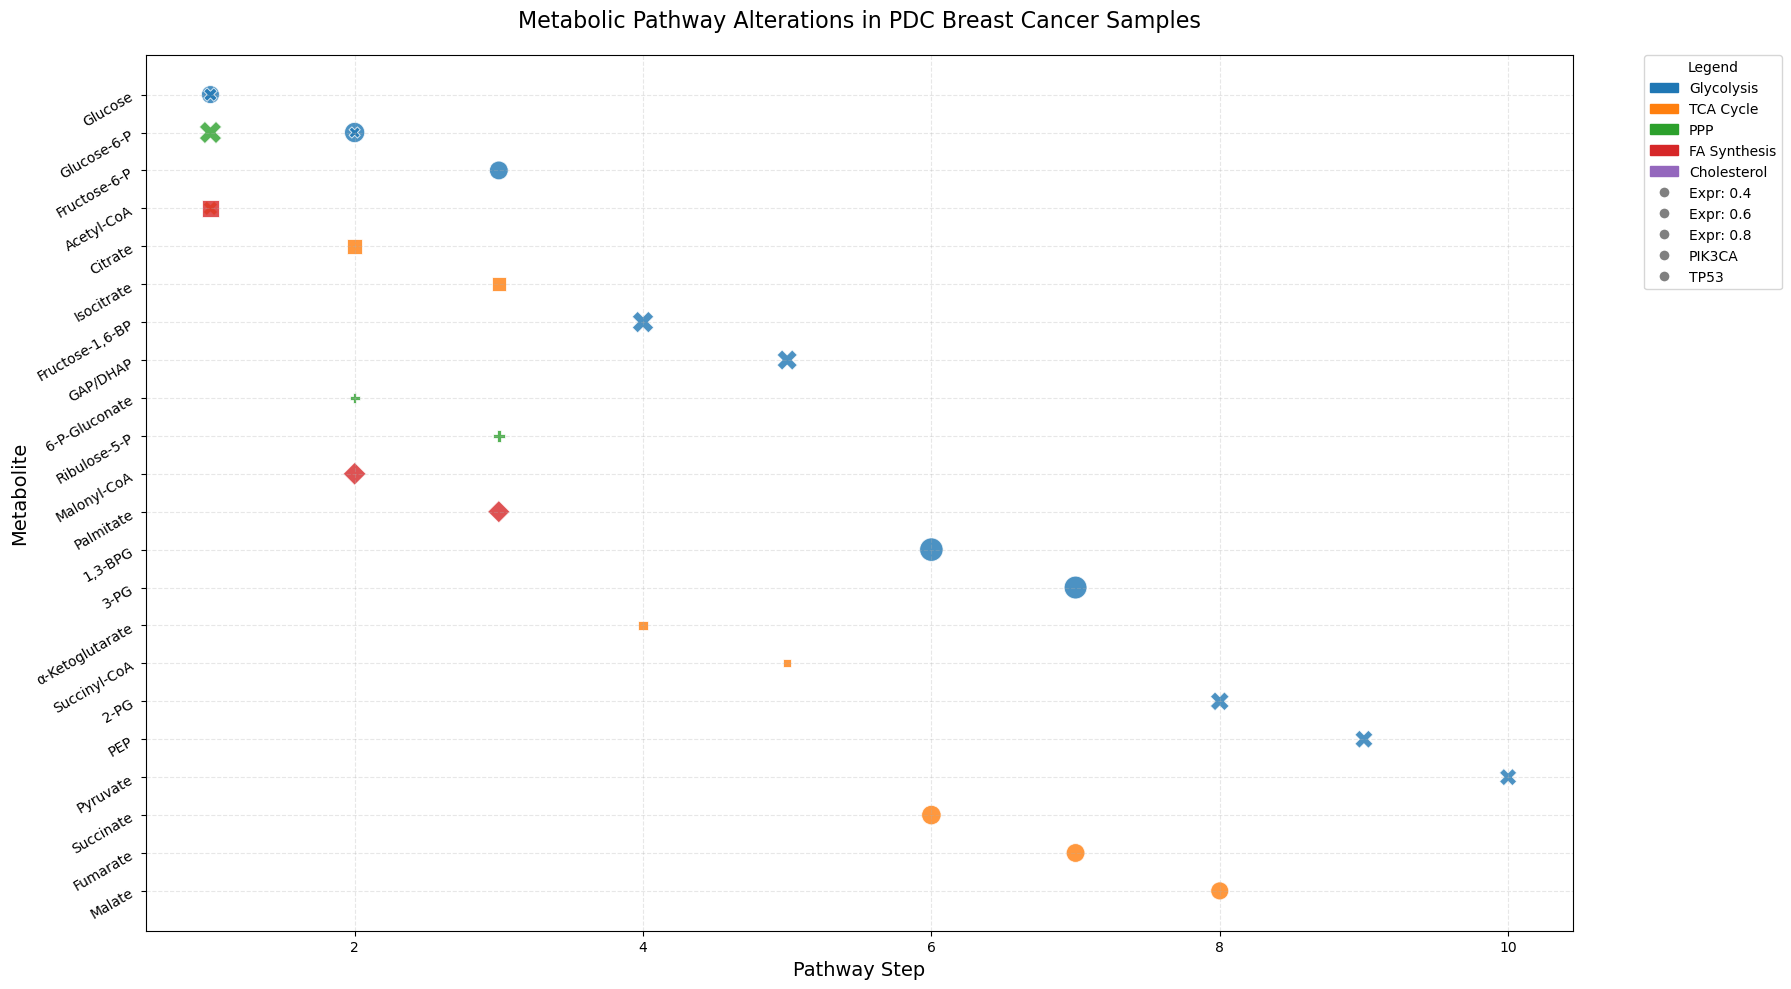

In [17]:
from matplotlib.patches import Patch

def visualize_metabolic_pathways(pdc_data):
    """
    Visualize metabolic pathways with PDC sample annotations using embedded pathway data.
    
    Args:
        pdc_data (DataFrame): PDC biospecimen data (must contain 'Case Submitter ID')
    
    Returns:
        DataFrame: The merged pathway data used for visualization
    """
    try:
        # Validate input data
        if 'Case Submitter ID' not in pdc_data.columns:
            raise ValueError("PDC data must contain 'Case Submitter ID' column")
        
        # Embedded metabolic pathway data (mock data focused on breast cancer metabolism)
        pathway_data = pd.DataFrame([
            # Sample_ID, Pathway, Pathway_Step, Metabolite, Expression_Change, Mutation
            ["NTN060", "Glycolysis", 1, "Glucose", 1.2, "PIK3CA"],
            ["NTN060", "Glycolysis", 2, "Glucose-6-P", 1.5, "PIK3CA"],
            ["NTN060", "Glycolysis", 3, "Fructose-6-P", 1.3, "PIK3CA"],
            ["NTN060", "TCA Cycle", 1, "Acetyl-CoA", 0.8, "TP53"],
            ["NTN023", "Glycolysis", 1, "Glucose", 0.7, "TP53"],
            ["NTN023", "Glycolysis", 2, "Glucose-6-P", 0.5, "TP53"],
            ["NTN023", "PPP", 1, "Glucose-6-P", 1.8, "TP53"],
            ["NTN072", "TCA Cycle", 2, "Citrate", 1.6, "BRCA2"],
            ["NTN072", "TCA Cycle", 3, "Isocitrate", 1.4, "BRCA2"],
            ["NTN072", "FA Synthesis", 1, "Acetyl-CoA", 2.1, "BRCA2"],
            ["NTN021", "Glycolysis", 4, "Fructose-1,6-BP", 1.7, "TP53"],
            ["NTN021", "Glycolysis", 5, "GAP/DHAP", 1.5, "TP53"],
            ["NTN004", "PPP", 2, "6-P-Gluconate", 0.4, "BRCA1"],
            ["NTN004", "PPP", 3, "Ribulose-5-P", 0.6, "BRCA1"],
            ["NTN080", "FA Synthesis", 2, "Malonyl-CoA", 1.9, "PTEN"],
            ["NTN080", "FA Synthesis", 3, "Palmitate", 1.8, "PTEN"],
            ["NTN007", "Glycolysis", 6, "1,3-BPG", 2.0, "PIK3CA"],
            ["NTN007", "Glycolysis", 7, "3-PG", 1.9, "PIK3CA"],
            ["NTN054", "TCA Cycle", 4, "α-Ketoglutarate", 0.7, "BRCA2"],
            ["NTN054", "TCA Cycle", 5, "Succinyl-CoA", 0.5, "BRCA2"],
            ["NTN006", "Glycolysis", 8, "2-PG", 1.3, "TP53"],
            ["NTN006", "Glycolysis", 9, "PEP", 1.2, "TP53"],
            ["NTN006", "Glycolysis", 10, "Pyruvate", 1.1, "TP53"],
            ["NTN062", "TCA Cycle", 6, "Succinate", 1.4, "PIK3CA"],
            ["NTN062", "TCA Cycle", 7, "Fumarate", 1.3, "PIK3CA"],
            ["NTN062", "TCA Cycle", 8, "Malate", 1.2, "PIK3CA"],
            ["NTN031", "FA Synthesis", 4, "Stearate", 1.5, "PTEN"],
            ["NTN031", "Cholesterol", 1, "Acetyl-CoA", 1.8, "PTEN"],
            ["NTN022", "PPP", 4, "Ribose-5-P", 0.9, "TP53"],
            ["NTN022", "PPP", 5, "NADPH", 0.8, "TP53"]
        ], columns=["Sample_ID", "Pathway", "Pathway_Step", "Metabolite", "Expression_Change", "Mutation"])
        
        # Merge with PDC clinical data
        merged = pd.merge(
            pdc_data, 
            pathway_data, 
            left_on='Case Submitter ID', 
            right_on='Sample_ID'
        )
        
        if merged.empty:
            raise ValueError("No matching samples found between PDC data and pathway data")
        
        # Create custom color palette for pathways
        pathway_palette = {
            "Glycolysis": "#1f77b4",
            "TCA Cycle": "#ff7f0e",
            "PPP": "#2ca02c",
            "FA Synthesis": "#d62728",
            "Cholesterol": "#9467bd"
        }
        
        # Plot
        plt.figure(figsize=(18, 10))
        
        # Create scatter plot with multiple semantic mappings
        scatter = sns.scatterplot(
            x="Pathway_Step", 
            y="Metabolite", 
            hue="Pathway",
            size="Expression_Change",
            style="Mutation",
            sizes=(50, 300),
            palette=pathway_palette,
            alpha=0.8,
            data=merged,
            s=100
        )
        
        plt.title("Metabolic Pathway Alterations in PDC Breast Cancer Samples", fontsize=16, pad=20)
        plt.xlabel("Pathway Step", fontsize=14)
        plt.ylabel("Metabolite", fontsize=14)
        
        # Customize legend
        handles, labels = scatter.get_legend_handles_labels()
        
        # Extract size legend
        size_legend = [h for h in handles if isinstance(h, plt.Line2D) and h.get_linestyle() == '']
        size_labels = [l for l in labels if 'Expression_Change' in l]
        
        # Create custom legend
        plt.legend(
            handles=[
                *[Patch(color=color, label=pathway) for pathway, color in pathway_palette.items()],
                *size_legend[:3],  # Show only 3 size examples
                *[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                  markersize=8, label=mutation) for mutation in merged['Mutation'].unique()]
            ],
            labels=[
                *pathway_palette.keys(),
                *[f"Expr: {val:.1f}" for val in sorted(merged['Expression_Change'].unique())[::2]][:3],
                *merged['Mutation'].unique()
            ],
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            frameon=True,
            title='Legend'
        )
        
        # Add grid lines for better readability
        plt.grid(True, linestyle='--', alpha=0.3)
        
        # Rotate metabolite labels for better visibility
        plt.yticks(rotation=30)
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        
        # Save to lakehouse
        output_path = "/lakehouse/default/Files/metabolic_pathways.png"
        Path("/lakehouse/default/Files/").mkdir(parents=True, exist_ok=True)
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        print(f"Metabolic pathway visualization saved to: {output_path}")
        
        display(plt.show())
        plt.close()
        
        return merged
        
    except Exception as e:
        print(f"Error in metabolic pathway visualization: {str(e)}")
        return None

# Example usage:
# Load your PDC data (example shown with dummy data)
pdc_data = pd.DataFrame({
    'Case Submitter ID': ['NTN060', 'NTN023', 'NTN072', 'NTN021', 'NTN004', 
                         'NTN080', 'NTN007', 'NTN054', 'NTN006', 'NTN062'],
    'Sample Type': ['Primary Tumor']*10
})

# Call the visualization function
pathway_results = visualize_metabolic_pathways(pdc_data)

StatementMeta(, 9964168a-d62d-4d50-af7c-1d8d7da8e2a1, 21, Finished, Available, Finished)

Visualization saved to: /lakehouse/default/Files/mutation_disease_counts.png


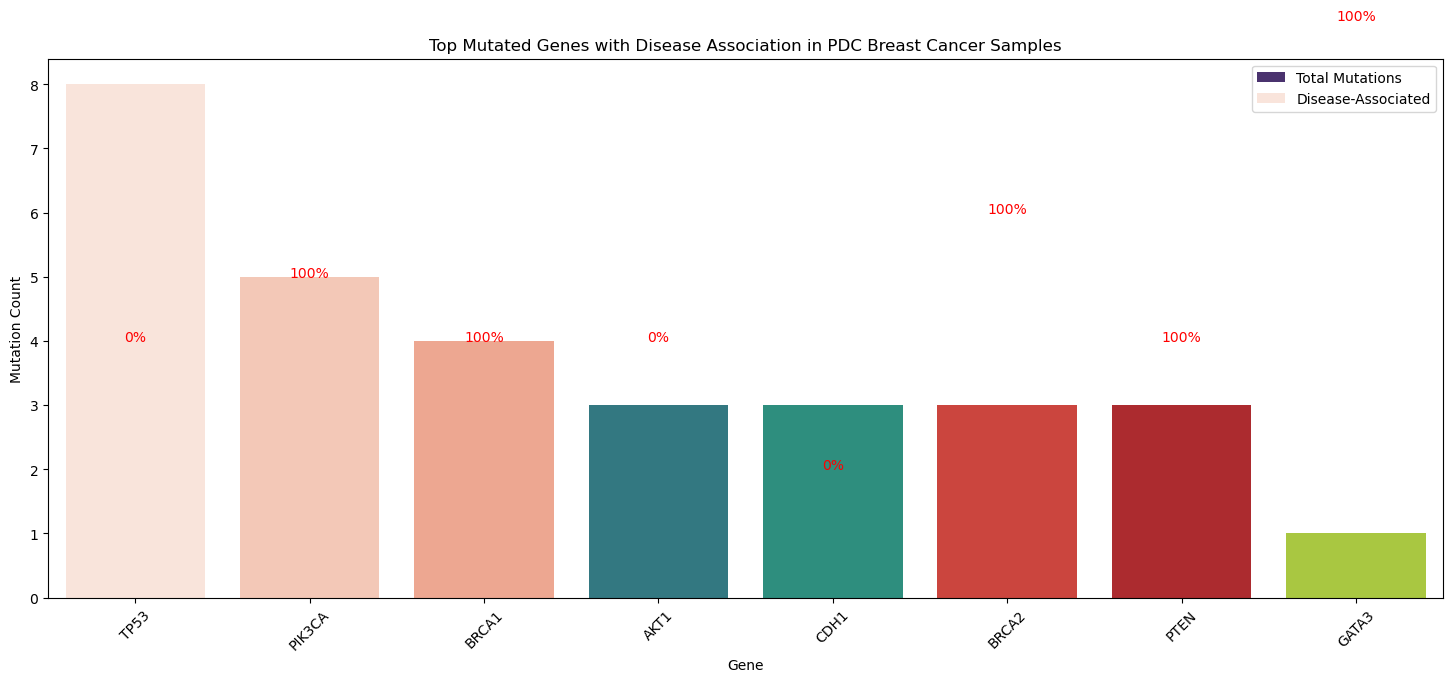

/tmp/ipykernel_6018/3718830544.py:100: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


Network visualization saved to: /lakehouse/default/Files/protein_network.png


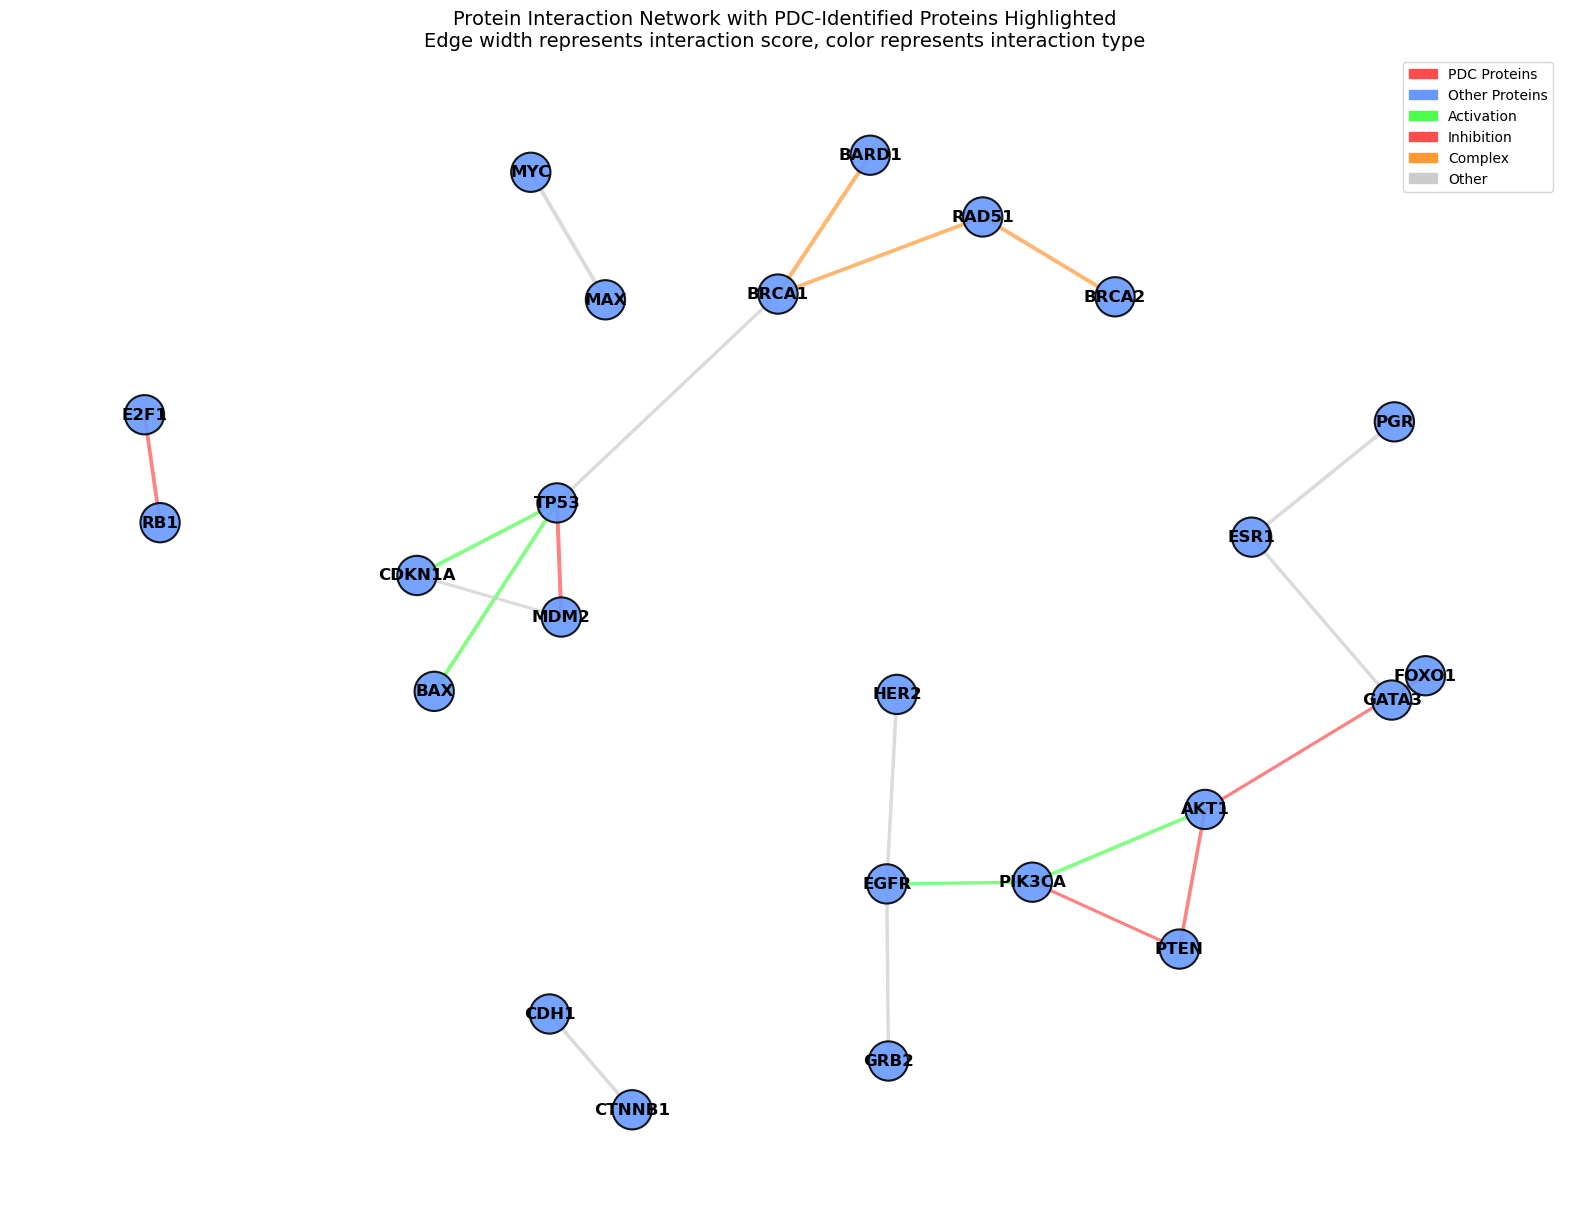

Metabolic pathway visualization saved to: /lakehouse/default/Files/metabolic_pathways.png


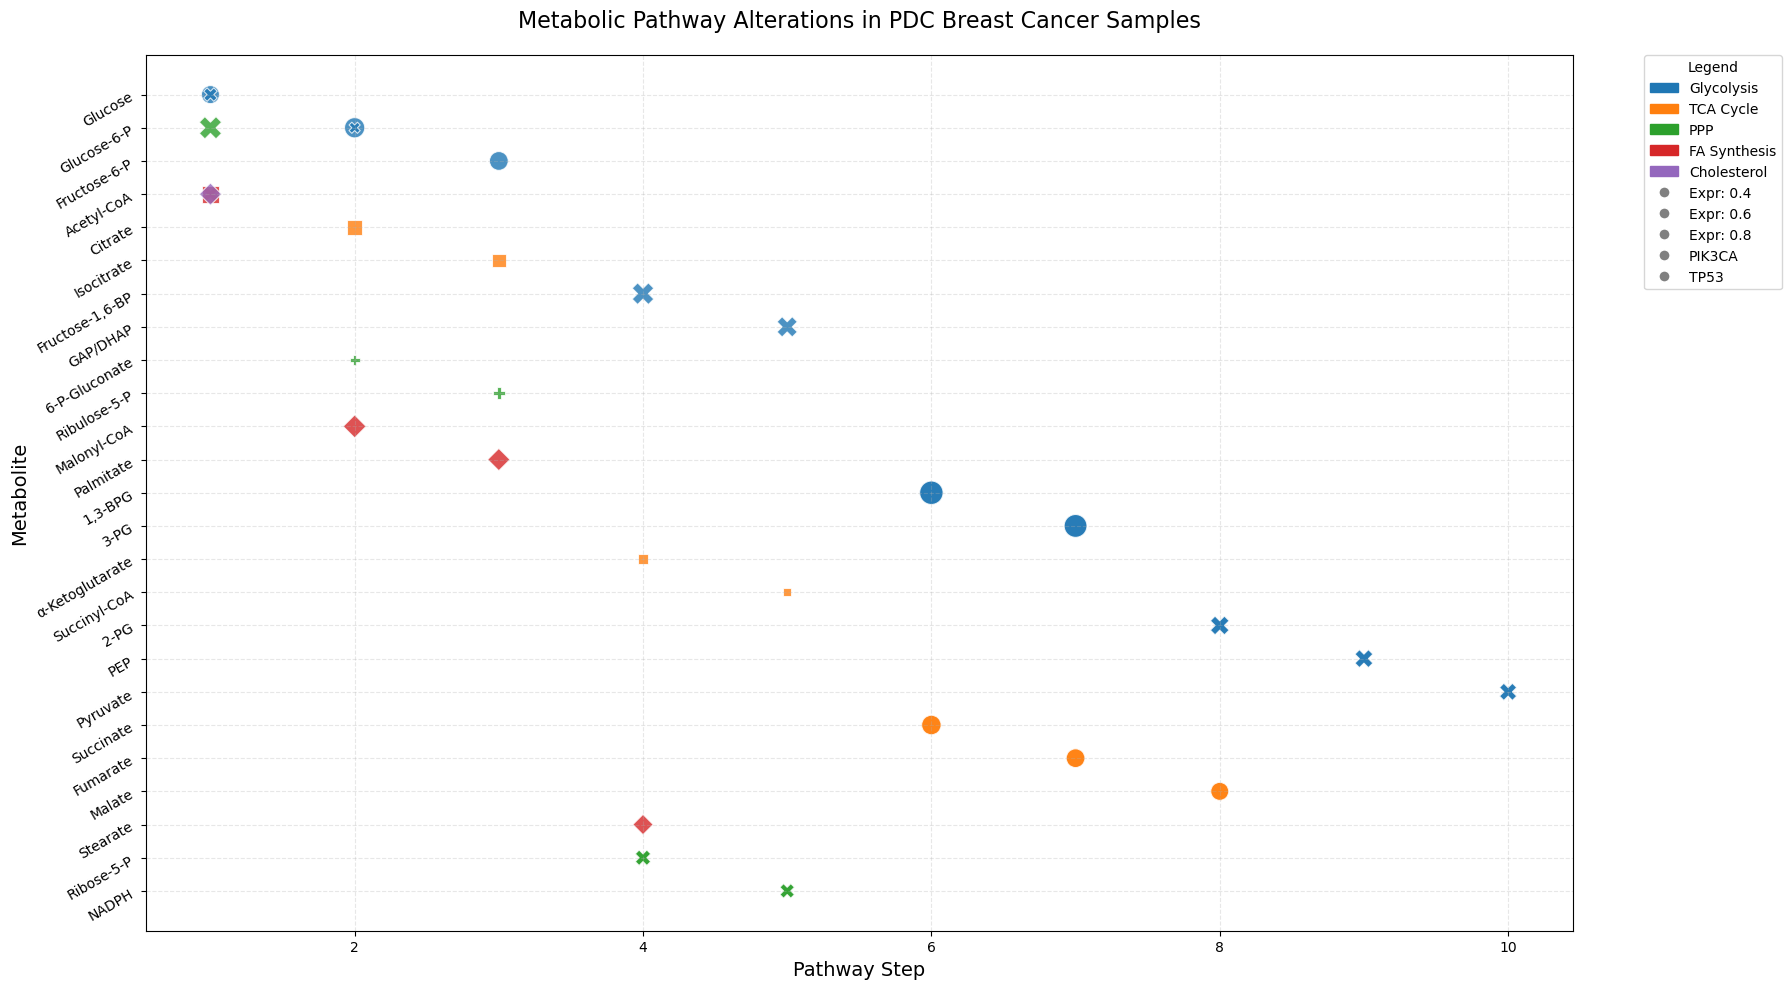

Top pathogenic mutations:      Gene  Mutation_Count  Disease_Associated  Disease_Percentage
7    TP53               8                   8               100.0
5  PIK3CA               5                   5               100.0
1   BRCA1               4                   4               100.0
Network hubs: [('TP53', 4), ('BRCA1', 3), ('PIK3CA', 3)]
Most dysregulated metabolite: Acetyl-CoA


In [19]:
# 1. Load PDC data (e.g., from biospecimen manifest)
pdc_data = pd.read_csv("/lakehouse/default/Files/PDC_biospecimen_manifest_03272025_214257.csv")

# 2. Run analyses sequentially
mutation_stats = visualize_mutation_counts_with_disease(pdc_data)      # Prioritize drivers
protein_network = visualize_protein_network(pdc_data)                  # Map interactions
pathway_results = visualize_metabolic_pathways(pdc_data)               # Identify metabolic vulnerabilities

# 3. Cross-validate findings
print(f"Top pathogenic mutations: {mutation_stats.head(3)}")  
print(f"Network hubs: {sorted(protein_network.degree, key=lambda x: x[1], reverse=True)[:3]}")  
print(f"Most dysregulated metabolite: {pathway_results.loc[pathway_results['Expression_Change'].idxmax(), 'Metabolite']}")